# Parametros

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy.signal import butter, lfilter

# Parámetros del sistema
FS = 48000          # Hz
FC = 10000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128           # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps


# Grabar desde el microfono

In [4]:
def record_audio(fs=48000, max_duration=10.0):
    """
    Graba audio mono desde el micrófono durante max_duration segundos.
    Devuelve:
        t_full : vector de tiempo [s]
        rx_raw : señal cruda (float32, 1D)
    """
    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    rx_raw = recording[:, 0]
    t_full = np.arange(len(rx_raw)) / fs
    return t_full, rx_raw


# Filtrar Señal

In [5]:
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    """
    Aplica un filtro pasa banda Butterworth de orden 'order' entre
    lowcut y highcut (en Hz).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Normalizar la señal

In [6]:
# ============================
# 2. NORMALIZACIÓN DE ENERGÍA
# ============================
def normalize_signal(x, eps=1e-12):
    """
    Normaliza la señal a su valor absoluto máximo.
    Devuelve una copia normalizada.
    """
    max_val = np.max(np.abs(x)) + eps
    return x / max_val


# Graficacion

In [7]:

def plot_signal(t, x, title="Señal", xlabel="Tiempo [s]"):
    plt.figure(figsize=(10, 4))
    plt.plot(t, x, linewidth=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()

def plot_raw_and_filtered(t, rx_raw, rx_filtered, lowcut, highcut):
    """
    Grafica la señal cruda y la señal filtrada.
    """
    # Señal cruda
    plot_signal(t, rx_raw, title="Señal recibida cruda desde el micrófono")

    # Señal filtrada
    plt.figure(figsize=(10, 4))
    plt.plot(t, rx_filtered, linewidth=0.8)
    plt.title(f"Señal recibida filtrada (Pasa Banda {lowcut:.1f}-{highcut:.1f} Hz)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()



# Downconvertion

In [10]:
def downconvert_to_baseband(rx_filtered, fc, fs):
    """
    Convierte una señal REAL pasabanda centrada en fc (Hz) a una
    señal COMPLEJA en banda base multiplicando por e^{-j 2π f_c n / f_s}.

    Parámetros:
        rx_filtered : np.ndarray real, salida del filtro pasa banda
        fc          : frecuencia de portadora (Hz)
        fs          : frecuencia de muestreo (Hz)

    Devuelve:
        t           : vector de tiempo [s]
        rx_bb       : señal compleja en banda base
    """
    n = np.arange(len(rx_filtered))
    t = n / fs

    # Exponencial compleja para bajar de fc a 0 Hz
    osc = np.exp(-1j * 2.0 * np.pi * fc * t)

    rx_bb = rx_filtered * osc
    return t, rx_bb

# Alto Nivel

🎙 Grabando desde el micrófono por máximo 10.0 s...
✔ Grabación finalizada.


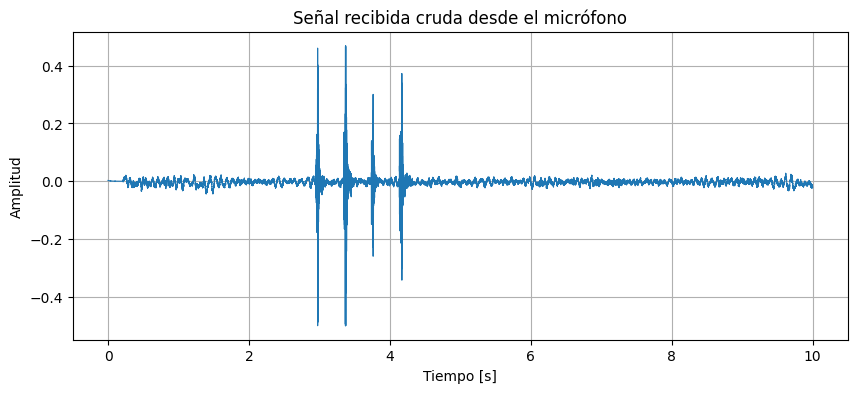

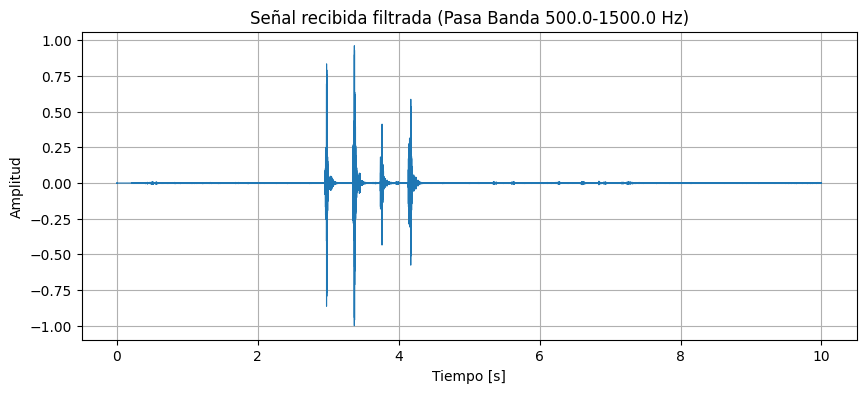

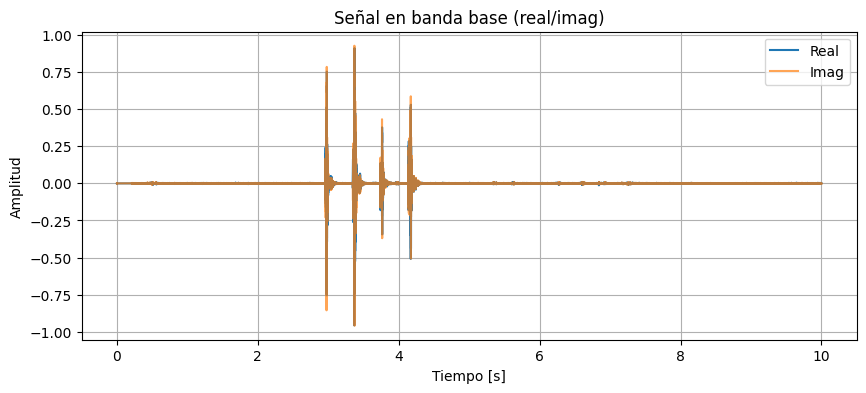

In [12]:
# ============================================
# PIPELINE ACTUAL DEL RECEPTOR (ETAPAS 0–2)
# ============================================
def receive_frontend(fs=48000,
                     max_duration=10.0,
                     fc=1000.0,
                     bw=500.0,
                     bp_order=2,
                     do_plots=True):
    """
    Front-end actual del receptor:
      0) Graba desde el micrófono
      1) Aplica filtro pasa banda alrededor de fc con ancho bw
      2) Normaliza la señal filtrada
      3) (Opcional) Grafica señal cruda y filtrada

    Devuelve:
      t_full      : vector de tiempo
      rx_raw      : señal cruda
      rx_filtered : señal filtrada y normalizada
    """
    # 0) Grabación
    t_full, rx_raw = record_audio(fs=fs, max_duration=max_duration)

    # 1) Filtro pasa banda
    lowcut = fc - bw
    highcut = fc + bw
    rx_bp = bandpass_filter(rx_raw, lowcut, highcut, fs, order=bp_order)

    # 2) Normalización
    rx_filtered = normalize_signal(rx_bp)

    # 3) Gráficas (opcional)
    if do_plots:
        plot_raw_and_filtered(t_full, rx_raw, rx_filtered, lowcut, highcut)

    return t_full, rx_raw, rx_filtered


def receive_baseband(fs=48000,
                     max_duration=10.0,
                     fc=1000.0,
                     bw=500.0,
                     bp_order=2,
                     do_plots=True):
    """
    Front-end + downconversion:
      0) Graba audio
      1) Filtro pasa banda
      2) Normalización
      3) Downconversion a banda base compleja

    Devuelve:
      t_full      : vector de tiempo
      rx_raw      : señal cruda
      rx_filtered : señal filtrada y normalizada (real)
      t_bb        : vector de tiempo (igual que t_full)
      rx_bb       : señal COMPLEJA en banda base
    """
    # Front-end (lo que ya tenías)
    t_full, rx_raw, rx_filtered = receive_frontend(
        fs=fs,
        max_duration=max_duration,
        fc=fc,
        bw=bw,
        bp_order=bp_order,
        do_plots=do_plots
    )

    # Downconversion a banda base
    t_bb, rx_bb = downconvert_to_baseband(rx_filtered, fc, fs)

    return t_full, rx_raw, rx_filtered, t_bb, rx_bb
FS = 48000
FC = 1000.0
BW = 500.0

t_full, rx_raw, rx_filtered, t_bb, rx_bb = receive_baseband(
    fs=FS,
    max_duration=10.0,
    fc=FC,
    bw=BW,
    bp_order=2,
    do_plots=True
)

# Opcional: ver partes real/imag de la banda base
plt.figure(figsize=(10,4))
plt.plot(t_bb, rx_bb.real, label='Real')
plt.plot(t_bb, rx_bb.imag, label='Imag', alpha=0.7)
plt.title("Señal en banda base (real/imag)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()


<!-- # Graficacion -->